In [56]:
import scanpy as sc
import anndata as ad

def plot_umap(counts_df, batch, group, colorby, axis=None, palette='tab20'):
    adata = ad.AnnData(counts_df.copy().T.values)
    adata.obs["batch"] = batch
    adata.obs["group"] = group.groups.tolist()
    
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
        
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_pcs=40)

    sc.tl.umap(adata)

    sc.pl.umap(adata, color=colorby, palette=palette, ax=axis, show=False, legend_loc=None)


In [57]:
import pandas as pd
import numpy as np

# read in data
counts = pd.read_csv("iter1_batch_df.csv", index_col=0)
covmat =  pd.read_csv("covmat.csv", index_col=0)

sample_count = 2**10

batches = [1]*int(sample_count/2) + [2]*int(sample_count/2)
group = pd.DataFrame(np.array(["group1"]*int(sample_count/4) + ["group2"]*int(sample_count/4) + 
                              ["group1"]*int(sample_count/4) + ["group2"]*int(sample_count/4)))
group = group.rename(columns={0:"groups"})

covmat.reset_index(inplace=True, drop=True)
covmat["group"] = group
covmat = covmat.astype(str)

In [58]:
import time
import pyrecombatseq.pycombat as pcb

start = time.time()
adjusted_reg = pcb.pycombat_seq(counts=counts, batch=batches, covar_mod=covmat, 
                            alpha_reg=0.3, lambda_reg=0.8)
end = time.time()

print(f"Time elapsed: {(end-start)} sec.")

[INFO] Found 2 batches
[INFO] Adjusting for 9 covariate(s) or covariate level(s)
[INFO] Estimating dispersions
[INFO] Fitting the GLM model
[INFO] shrinkage off - using GLM estimates for parameters
[INFO] Adjusting the data


Time elapsed: 208.36536979675293 sec.


In [59]:
start = time.time()
adjusted = pcb.pycombat_seq(counts=counts, batch=batches, covar_mod=covmat, 
                            alpha_reg=0, lambda_reg=0)
end = time.time()

print(f"Time elapsed: {(end-start)} sec.")

[INFO] Found 2 batches
[INFO] Adjusting for 9 covariate(s) or covariate level(s)
[INFO] Estimating dispersions
[INFO] Fitting the GLM model
[INFO] shrinkage off - using GLM estimates for parameters
[INFO] Adjusting the data


Time elapsed: 17.32750105857849 sec.


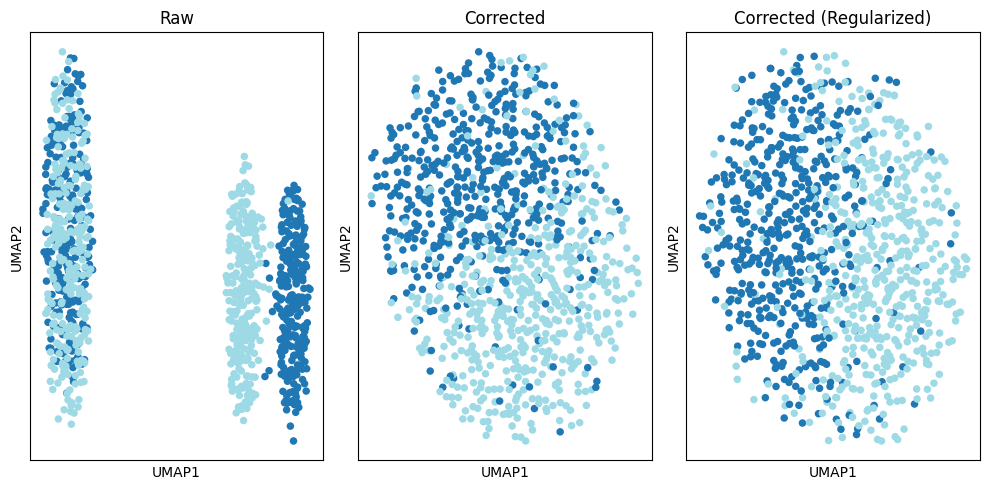

In [64]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3)

plot_umap(counts, batches, group, colorby="group", axis=axes[0])
plot_umap(adjusted, batches, group, colorby="group", axis=axes[1])
plot_umap(adjusted_reg, batches, group, colorby="group", axis=axes[2])

axes[0].set_title("Raw")
axes[1].set_title("Corrected")
axes[2].set_title("Corrected (Regularized)")

fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout()